## Random simulation

Simulate the gacha rules iteratively and record the results.

In [59]:
from random import random

def simulate(sims):
  proms = 0
  wanted = 0

  guaranteed = False
  path = 0

  def show(text, count):
    print(f"{text}: {count} ({count/sims*100:.2f}%)")

  def chance(p):
    return random() <= p

  def chance_prom():
    return 1 if guaranteed or path >= 2 else 0.75

  def chance_wanted():
    return 0.5 if path < 2 else 1

  for _ in range(sims):
    if chance(chance_prom()):
      proms += 1
      guaranteed = False
      if(chance(chance_wanted())):
        path = 0
        wanted += 1
      else:
        path += 1
    else:
      guaranteed = True
      path += 1

  show("Obtained 5* Items", sims)
  show("Obtained promotional items", proms)
  show("Obtained permanent items", sims - proms)
  show("Obtained wanted promotional items", wanted)

simulate(100)




Obtained 5* Items: 100 (100.00%)
Obtained promotional items: 88 (88.00%)
Obtained permanent items: 12 (12.00%)
Obtained wanted promotional items: 49 (49.00%)


## Calculation via Markov chains

In [60]:
!apt -qqq install graphviz

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [61]:
%%writefile chain.dot
# The markov chain diagram
digraph chain {

  per1[label="Permanent (1/2)"];
  per2[label="Permanent (2/2)"];
  prom10[label="Wanted promotional (0/2)"];
  prom21[label="Not wanted promotional (1/2)"];
  prom22[label="Not wanted promotional (2/2)"];

  per1->prom10 [label="0.5"];
  per1->prom22 [label="0.5"];
  prom10->prom10 [label="0.375"];
  prom10->prom21 [label="0.375"];
  prom10->per1 [label="0.25"];
  prom21->prom10 [label="0.375"];
  prom21->prom22 [label="0.375"];
  prom21->per2 [label="0.25"];
  per2->prom10 [label="1"];
  prom22->prom10 [label="1"];
}

Writing chain.dot


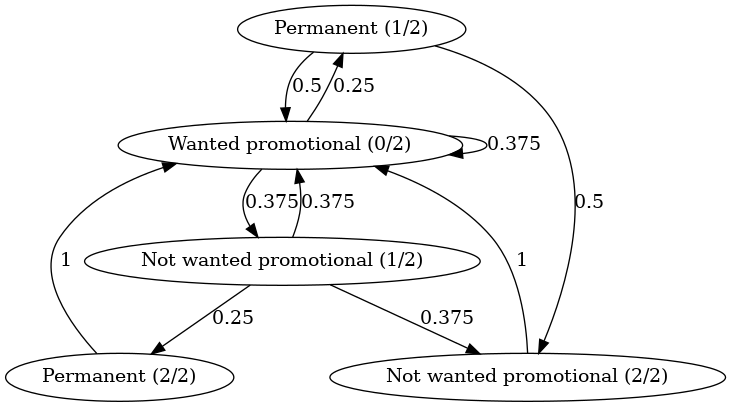

In [62]:
!dot -Tpng chain.dot > chain.png
from IPython.display import Image
Image('chain.png')

In [63]:
!rm chain.dot chain.png

-- | permanent (1/2) | permanent (2/2) | wanted promotional (0/2) | not wanted promotional (1/2) | not wanted promotional (2/2)
--|--|--|--|--|--
permanent (1/2) | 0 | 0 | 0.5 | 0 | 0.5
permanent (2/2) | 0 | 0 | 1 | 0 | 0
wanted promotional (0/2) | 0.25 | 0 | 0.375 | 0.375 | 0
not wanted promotional (1/2) | 0 | 0.25 | 0.375 | 0 | 0.375
wanted promotional (2/2) | 0 | 0 | 1 | 0 | 0

In [64]:
import numpy as np
import sympy

In [65]:
M = sympy.Matrix([
  [0, 0, 0.5, 0, 0.5],
  [0, 0, 1, 0, 0],
  [0.25, 0, 0.375, 0.375, 0],
  [0, 0.25, 0.375, 0, 0.375],
  [0, 0, 1, 0, 0],
])
M

Matrix([
[   0,    0,   0.5,     0,   0.5],
[   0,    0,     1,     0,     0],
[0.25,    0, 0.375, 0.375,     0],
[   0, 0.25, 0.375,     0, 0.375],
[   0,    0,     1,     0,     0]])

In [66]:
x = sympy.symbols("x0:5")
X = sympy.Matrix(x).T
X

Matrix([[x0, x1, x2, x3, x4]])

In [67]:
eq1 = X - X*M
eq2 = sum(x) - 1

display(eq1, eq2)
_sol = sympy.solve((eq1, eq2), x)
sol = []
for _x in x:
  sol.append(_sol[_x])
sol

Matrix([[x0 - 0.25*x2, x1 - 0.25*x3, -0.5*x0 - x1 + 0.625*x2 - 0.375*x3 - x4, -0.375*x2 + x3, -0.5*x0 - 0.375*x3 + x4]])

x0 + x1 + x2 + x3 + x4 - 1

[0.125984251968504,
 0.0472440944881890,
 0.503937007874016,
 0.188976377952756,
 0.133858267716535]

In [68]:
def show(text, rate):
  print(f"{text}: {rate} ({rate*100:.2f}%)")

In [69]:
show("Permanent item rate", sum(sol[0:2]))
show("Promotional item rate", sum(sol[2:5]))
show("Wanted promotional item rate", sol[2])

Permanent item rate: 0.173228346456693 (17.32%)
Promotional item rate: 0.826771653543307 (82.68%)
Wanted promotional item rate: 0.503937007874016 (50.39%)
